# Auditing Bias of Machine Learning Algorithms

In this tutorial, we audit a machine learning model in terms of its fairness property. Our focus is on group fairness, a popular paradigm of fairness notions that try to establish equity in prediction across different demographic groups in the data based on sensitive features: race, gender, etc. By the end of this notebook, the audience will be demonstrated a formal framework for quantifying bias or unfairness in machine learning and a framework to explain bias in terms of participating feature combinations in the data.
- **Formal Quantification of Bias:** We deploy a recently developed formal fairness quantifier `Justicia` to quantify the bias of a machine learning classifier that relies on the probability distribution of features to measure the bias of the classifier. (https://github.com/meelgroup/justicia)
- **Fairness Enhancing Algorithms** We demonstrate to improve unfairness by applying a pre-processing *reweighing*-based fairness algorithms from AIF360, an extensive library of fairness algorithms (https://github.com/ReAILe/bias-explainer)
- **Explaining Sources of Bias:** We rely on a fairness explainer, called `FairXplainer` to decompose the bias of the classifier among unfairness contributions of different combinations of features. (https://github.com/ReAILe/bias-explainer)
- For experiments, we consider recently introduced US census datasets incorporated in a python package `folktables`. The details of the dataset is here: https://github.com/socialfoundations/folktables

In [1]:
# Necessary libraries (see README.md for installation instructions)
from folktables import ACSDataSource, ACSEmployment, generate_categories
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from justicia.metrics import Metric
import aif360
from sklearn import svm
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.reweighing import Reweighing
from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils
from sklearn.metrics import classification_report



fontsize = 18
labelsize = 16



good_name_features = {
        'AGEP' : 'Age',
        'SCHL' : 'Education',
        'MAR' : 'Marital_status',
        'RELP' : 'Relationship',
        'DIS' : 'Disability',
        'ESP' : "Parent's_employment",
        'CIT' : 'Citizenship',
        'MIG' : 'Mobility_status',
        'MIL' : 'Military_service',
        'ANC' : 'Ancestry',
        'NATIVITY' : 'Nativity',
        'DEAR' : 'Hearing_difficulty',
        'DEYE' : 'Vision_difficulty',
        'DREM' : 'Cognitive_difficulty',
        'SEX' : 'Sex',
        'RAC1P' : 'Race'
}

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


### Dataset

In [2]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
definition_df = data_source.get_definitions(download=True)
acs_data = data_source.get_data(states=["AL"], download=True)
features_unscaled, label, group = ACSEmployment.df_to_pandas(acs_data)
categories_ = generate_categories(features=features_unscaled, definition_df=definition_df)
categories = {}
for key in categories_.keys():    
    categories[good_name_features[key]] = categories_[key]
features_unscaled = features_unscaled.rename(columns=good_name_features)
features_unscaled.shape

(47777, 16)

### Preprocessing

In [3]:
features_unscaled.drop(['Citizenship', 'Ancestry', 'Nativity', "Parent's_employment"], axis=1, inplace=True) # dropping a few collumns
flag = (20 <= features_unscaled['Age']) & (features_unscaled['Age'] <= 60) # flagging the rows that have age between 20 and 60, as individuals outside this range are not in the labor force
label = label[flag]
features_unscaled = features_unscaled[flag]

features_unscaled.shape, label.shape

((23793, 12), (23793, 1))

### Sensitive features

We consider the following sensitive features:
- Sex
- Marital status
- Age

Among them, sex is binary, marital status is categorical, and age is continuous (requires binning)

In [4]:
feature_to_one_hot_encode = "Marital_status" # A sensitive feature. So we will one-hot encode it.
features_unscaled = features_unscaled.replace({feature_to_one_hot_encode : categories[feature_to_one_hot_encode]}) 
features_unscaled = utils.get_one_hot_encoded_df(features_unscaled, [feature_to_one_hot_encode]) 
for key in categories[feature_to_one_hot_encode]:
    val = categories[feature_to_one_hot_encode][key]
    categories[f'{feature_to_one_hot_encode}_' + val] = {1 : 'Yes', 0 : 'No'}
del categories[feature_to_one_hot_encode]

In [5]:
# We consider age as another sensitive feature and consider following age groups
features_unscaled['Age_less_than_30'] = features_unscaled['Age'] < 30
features_unscaled['Age_between_30_and_40'] = (features_unscaled['Age'] >= 30) & (features_unscaled['Age'] < 40)
features_unscaled['Age_between_40_and_50'] = (features_unscaled['Age'] >= 40) & (features_unscaled['Age'] < 50)
features_unscaled['Age_greater_than_50'] = features_unscaled['Age'] >= 50
features_unscaled.drop('Age', axis=1, inplace=True)


# update categories
categories['Age_less_than_30'] = {1 : 'Yes', 0 : 'No'}
categories['Age_between_30_and_40'] = {1 : 'Yes', 0 : 'No'}
categories['Age_between_40_and_50'] = {1 : 'Yes', 0 : 'No'}
categories['Age_greater_than_50'] = {1 : 'Yes', 0 : 'No'}

### Scaling dataset

In [6]:
scaler = MinMaxScaler()
features = features_unscaled.copy()
features[features.columns] = scaler.fit_transform(features[features.columns])
features

,Education,Relationship,Disability,Mobility_status,Military_service,Hearing_difficulty,Vision_difficulty,Cognitive_difficulty,Sex,Race,Marital_status_Divorced,Marital_status_Married,Marital_status_Never married or under 15 years old,Marital_status_Separated,Marital_status_Widowed,Age_less_than_30,Age_between_30_and_40,Age_between_40_and_50,Age_greater_than_50
2,0.695652,0.941176,0.0,0.0,1.000000,1.0,1.0,0.0,0.0,0.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.782609,0.941176,1.0,0.0,0.333333,1.0,1.0,1.0,0.0,0.000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.478261,0.941176,0.0,1.0,1.000000,1.0,1.0,0.0,1.0,0.000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.652174,0.941176,0.0,0.0,1.000000,1.0,1.0,0.0,1.0,0.000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.478261,0.941176,0.0,0.0,1.000000,0.0,1.0,1.0,0.0,0.000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47758,0.826087,0.000000,1.0,0.0,1.000000,1.0,1.0,1.0,1.0,0.000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
47759,0.652174,0.058824,1.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
47762,0.782609,0.235294,1.0,0.0,1.000000,1.0,1.0,1.0,0.0,0.000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
47765,0.652174,0.117647,1.0,0.0,1.000000,1.0,1.0,1.0,1.0,0.125,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Some helper functions

In [7]:
# mapping categories from unscaled to scaled
assert isinstance(scaler, MinMaxScaler)
categories_scaled = {}

for column in features_unscaled.columns:
    categories_scaled[column] = {}
    idx = list(features_unscaled.columns).index(column)
    if(column not in categories):
        continue
    for key in categories[column].keys():
        if(not math.isnan(key)):
            categories_scaled[column][key * scaler.scale_[idx] + scaler.min_[idx]] = categories[column][key]

# helper function to get group statistics from justicia result
def get_group_statistics(justicia_result):

    groups = []
    positive_prediction_probabilities = []
    for i in range(len(justicia_result.sensitive_group_statistics)):
        group_name_per_sensitive_feature = []
        for j in range(len(justicia_result.sensitive_group_statistics[i][0])):
            sensitive_feature = justicia_result.sensitive_group_statistics[i][0][j][0]
            operator = justicia_result.sensitive_group_statistics[i][0][j][1][0]
            value = justicia_result.sensitive_group_statistics[i][0][j][1][1]
            translated_value = None
            if(operator == '=='):
                translated_value = categories_scaled[sensitive_feature][value]
            else:
                translated_value = categories_scaled[sensitive_feature][1 - value]
            group_name_per_sensitive_feature.append(f"{sensitive_feature} = {translated_value}")
        
        groups.append(",\n".join(group_name_per_sensitive_feature))
        positive_prediction_probability = justicia_result.sensitive_group_statistics[i][1]
        positive_prediction_probabilities.append(round(positive_prediction_probability, 3))
        
    return groups, positive_prediction_probabilities

### Training

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.4, random_state=0)

model, model_name = LogisticRegression(solver='lbfgs', max_iter=10000), "lr"
# model, model_name = svm.SVC(kernel='linear'), "svm"
model.fit(X_train, y_train)


/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=10000)

### Classification Performance

In [9]:
yhat = model.predict(X_test)
print(classification_report(y_test, yhat, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.71      0.43      0.54      3053
           1       0.77      0.92      0.84      6465

    accuracy                           0.76      9518
   macro avg       0.74      0.67      0.69      9518
weighted avg       0.75      0.76      0.74      9518



## Formal fairness quantification

We consider three scenarios with different choices of sensitive features
- Sex
- Sex and age
- Sex and marital status


Sensitive features: ['Sex']


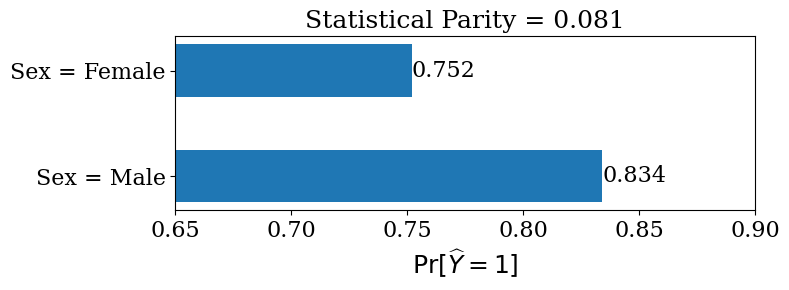


Sensitive features: ['Sex', 'Age']


<Figure size 800x300 with 0 Axes>

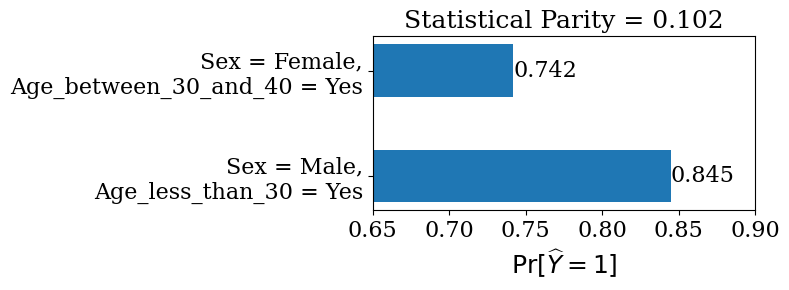


Sensitive features: ['Sex', 'Marital_status']


<Figure size 800x300 with 0 Axes>

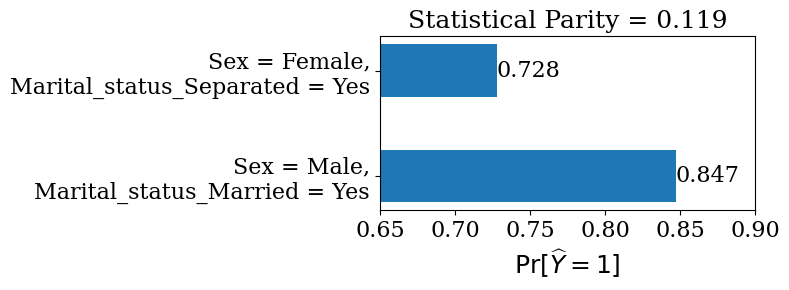

<Figure size 800x300 with 0 Axes>

In [10]:
justicia_results = []
for sensitive_feature_set in [['Sex'], ['Sex', 'Age'], ['Sex', 'Marital_status']]:

    metric = Metric(model=model, 
                    data=X_test, 
                    sensitive_attributes=sensitive_feature_set,
                    verbose=False,
                    discretization_bins=10,
                    encoding="best-correlated",
                    dag_threshold=0.6,
                    dag_filename=f"dag_{model_name}_" + "_".join(sensitive_feature_set) +".pkl")
    metric.compute()
    justicia_results.append(metric)



    # results
    print()
    print(f"Sensitive features: {sensitive_feature_set}")
    groups, positive_prediction_probabilities = get_group_statistics(justicia_results[-1])
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['figure.figsize'] = (8, 3)
    fig, ax = plt.subplots()
    bars = ax.barh(groups, positive_prediction_probabilities, 0.5)
    ax.bar_label(bars, fontsize=labelsize)
    plt.title(f"Statistical Parity = {round(justicia_results[-1].statistical_parity_difference, 3)}", fontsize=fontsize)
    plt.xlabel(r"$\Pr[\widehat{Y} = 1]$", fontsize=fontsize)
    # plt.ylabel("Sensitive groups", fontsize=fontsize)
    plt.xticks(fontsize=labelsize)
    plt.yticks(fontsize=labelsize)
    plt.xlim(0.65, 0.9) # careful, this is hardcoded
    plt.tight_layout()
    plt.show()
    plt.clf()




## Explaining the sources of unfairness

In [11]:
fairXplainer = FairXplainer(model, X_test, ['Sex', 'Marital_status'])
fairXplainer.compute(maxorder=2, spline_intervals=3, verbose=False, maxiter=10, cpu_time=2000)

### Individual influences

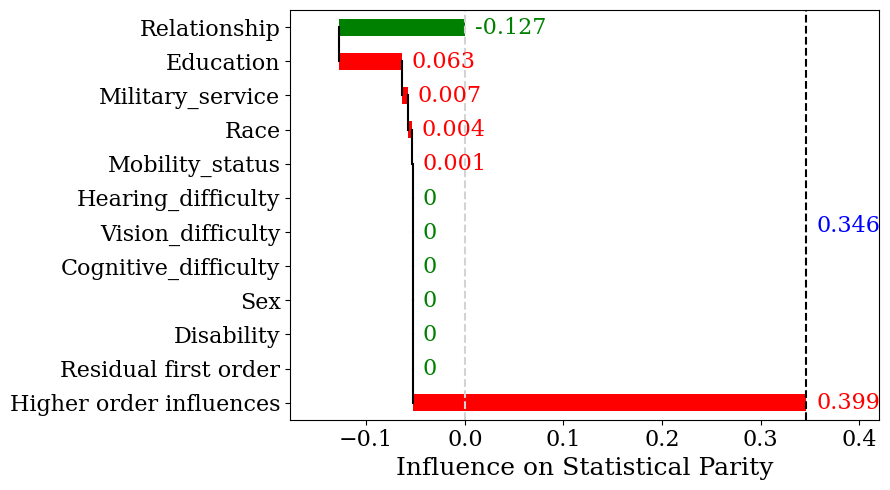

<Figure size 900x500 with 0 Axes>

In [12]:
k = 10
fairXplainer_result = fairXplainer.get_weights(k=k)
plt = fif_plot(fairXplainer_result, 
               draw_waterfall=True, 
               labelsize=labelsize,
               fontsize=fontsize,
               figure_size=(9,5), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on Statistical Parity"
        )
plt.tight_layout()
plt.show()
plt.clf()
# print("Exact statistical parity", fairXplainer.statistical_parity_sample())

## Intersectional influences

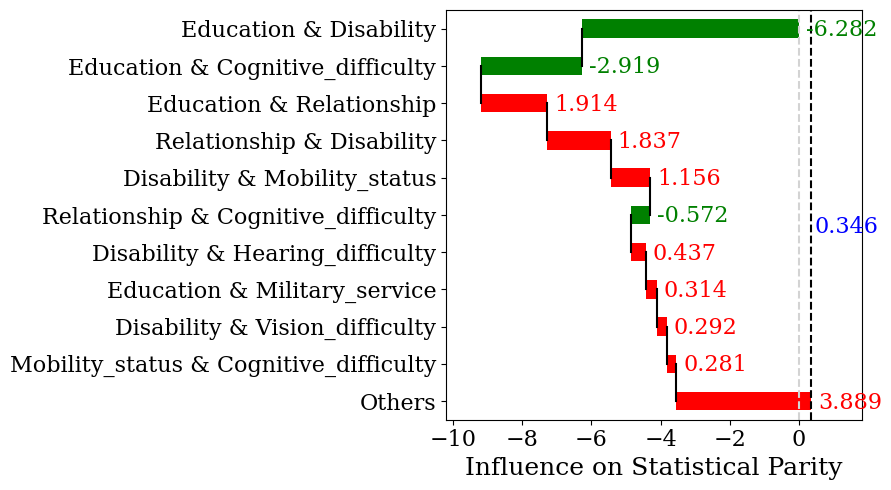

<Figure size 900x500 with 0 Axes>

In [13]:
k = 10
fairXplainer_result = fairXplainer.get_top_k_weights(k=k)

plt = fif_plot(fairXplainer_result, 
               draw_waterfall=True, 
               labelsize=labelsize,
               fontsize=fontsize, 
               figure_size=(9,5), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.01,
               x_label="Influence on Statistical Parity",
        )
plt.tight_layout()
plt.show()
plt.clf()

# Improving fairness by a pre-processing fairness algorithm

In [14]:
encoded_df_train = X_train.copy()
encoded_df_train['target'] = y_train

encoded_df_test = X_test.copy()
encoded_df_test['target'] = y_test


binary_label_dataset_train = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_train,
    label_names=['target'],
    protected_attribute_names=['Sex'])
binary_label_dataset_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_test,
    label_names=['target'],
    protected_attribute_names=['Sex'])


# Reweighing algorithm
rw = Reweighing(unprivileged_groups=[{'Sex' : 1}], privileged_groups=[{'Sex' : 0}])
rw.fit(binary_label_dataset_train)

binary_label_dataset_trans_train = rw.transform(binary_label_dataset_train)
dataset_transf_train = binary_label_dataset_trans_train.convert_to_dataframe()[0]
dataset_transf_test = rw.transform(binary_label_dataset_test).convert_to_dataframe()[0]

X_trans_train = dataset_transf_train.drop(['target'], axis = 1)
y_trans_train = dataset_transf_train['target']


X_trans_test = dataset_transf_test.drop(['target'], axis = 1)
y_trans_test = dataset_transf_test['target']



## Retraining after fairness repair

In [15]:
model_trans, model_trans_name = LogisticRegression(solver='lbfgs', max_iter=10000), "lr"
model_trans.fit(X_trans_train, y_trans_train, sample_weight= binary_label_dataset_trans_train.instance_weights)

LogisticRegression(max_iter=10000)

## Compare the difference in statistical parity with respect to Sex

Statistical Parity Before:  0.043
Statistical Parity After:  0.009


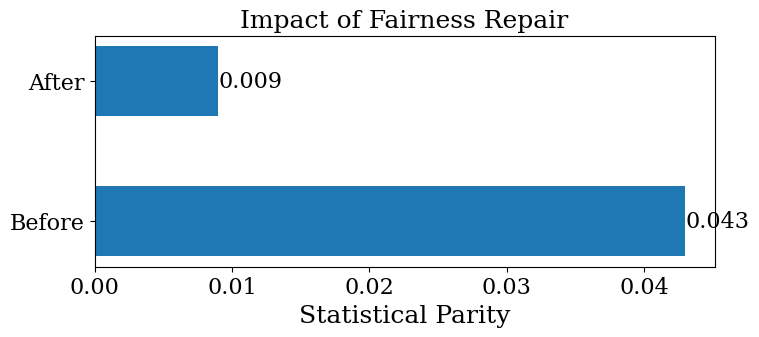

<Figure size 800x300 with 0 Axes>

In [16]:
fairXplainer_before = FairXplainer(model, X_test, ['Sex'])
fairXplainer_before.compute(compute_sp_only=True)
statistical_parity_before = round(fairXplainer_before.statistical_parity_sample(), 3)



fairXplainer_after = FairXplainer(model_trans, X_trans_test, ['Sex'])
fairXplainer_after.compute(compute_sp_only=True)
statistical_parity_after = round(fairXplainer_after.statistical_parity_sample(), 3)

print("Statistical Parity Before: ", statistical_parity_before)
print("Statistical Parity After: ", statistical_parity_after)

# bar plot of statistical parity before and after
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.figsize'] = (8, 3)
fig, ax = plt.subplots()
bars = ax.barh(['Before', 'After'], [statistical_parity_before, statistical_parity_after], 0.5)
ax.bar_label(bars, fontsize=labelsize)
plt.xlabel("Statistical Parity", fontsize=fontsize)
plt.title("Impact of Fairness Repair", fontsize=fontsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.show()
plt.clf()

## Explaining the sources of bias after fairness repair

In [17]:
fairXplainer_trans = FairXplainer(model_trans, X_trans_test, ['Sex'])
fairXplainer_trans.compute(maxorder=2, spline_intervals=3, verbose=False, maxiter=10, cpu_time=3000)

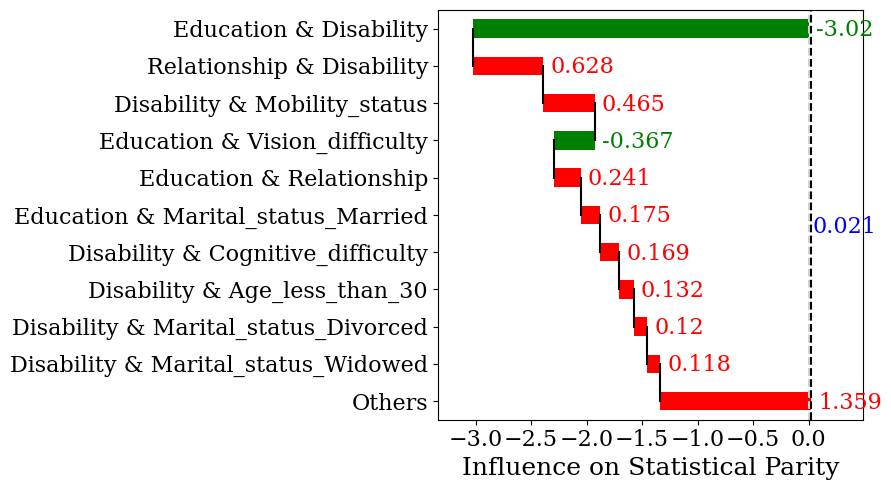

<Figure size 900x500 with 0 Axes>

In [18]:
k = 10
fairXplainer_trains_result = fairXplainer_trans.get_top_k_weights(k=k)

plt = fif_plot(fairXplainer_trains_result, 
               draw_waterfall=True, 
               labelsize=labelsize,
               fontsize=fontsize, 
               figure_size=(9,5), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.005,
               x_label="Influence on Statistical Parity"
)
plt.tight_layout()
plt.show()
plt.clf()